# How to use the su28 catalog

The catalog is builed using intake for the datasets hosted on the su28 project. This notebook provide some exaples on how to access the catalog and check the list of datasets and how to read data directly through the catalog. 

If you have questions or suggestions, plase contact the RSE team on Cumulus using the Software Support category.

In [2]:
import intake
import xarray as xr

In [7]:
data_catalog = intake.open_catalog("/g/data/su28/tools/su28_catalog/catalog/su28_catalog.yaml")
list(data_catalog)

['daily_era5']

For example, `daily_era5` includes 17 variables. 

In [9]:
daily_era5 = data_catalog['daily_era5'] # data_catalog.daily_era5 gives the same result
daily_era5

,unique
variable,17
dataset,1
level,2
resolution,1
frequency,1
year,75
name_in_file,17
long_name,17
units,11
path,1257


Other options to explore a dataset are:

* `daily_era5.df` returns a table with the list of files includes and the information available, this can be a very long table.
* `daily_era5.metadata` returns the available metadata
* `daily_era5.search()` allows you to search by a parameter. 

In [34]:
daily_era5.metadata

{'contact': 'RSE team',
 'created': 'May, 2025',
 'description': 'ERA5 data in daily frequency',
 'keywords': ['era5'],
 'license': None,
 'long_description': 'ERA5 is a climate reanalysis dataset, covering the period 1950 to present. This dataset includes 2d and 3d common variables in daily frequency. The data was also remaped from 0.25 degree to 1 degree. For the original datase check NCI project rt52.',
 'model': ['ERA5'],
 'name': 'daily_era5',
 'nominal_resolution': ['1degree'],
 'catalog_dir': '/g/data/su28/tools/su28_catalog/catalog/'}

In [44]:
daily_era5.search(variable = "2t")


,unique
variable,1
dataset,1
level,1
resolution,1
frequency,1
year,10
name_in_file,1
long_name,1
units,1
path,10


Let's search for the data asociated to precipitation and read it.

In [41]:
data_tp = daily_era5.search(variable = "tp", year = [2018, 2019, 2020]).to_dask()
data_tp

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


<xarray.Dataset> Size: 284MB
Dimensions:    (time: 1096, lat: 180, lon: 360, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 9kB 2018-01-01T11:00:00 ... 2020-12-31T1...
    time_bnds  (time, bnds) datetime64[ns] 18kB dask.array<chunksize=(1, 2), meta=np.ndarray>
  * lon        (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat        (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: bnds
Data variables:
    tp         (time, lat, lon) float32 284MB dask.array<chunksize=(1, 1, 360), meta=np.ndarray>
Attributes: (12/17)
    CDI:                             Climate Data Interface version 2.4.3 (ht...
    Conventions:                     CF-1.6
    license:                         Licence to use Copernicus Products: http...
    summary:                         ERA5 is the fifth generation ECMWF atmos...
    frequency:                       day
    CDO:                             Climate Data Operators version 2.4.3 (ht...
    ...                              ...
    intake_esm_attrs:frequency:      daily
    intake_esm_attrs:name_in_file:   tp
    intake_esm_attrs:long_name:      Total precipitation
    intake_esm_attrs:units:          m
    intake_esm_attrs:_data_format_:  netcdf
    intake_esm_dataset_key:          tp

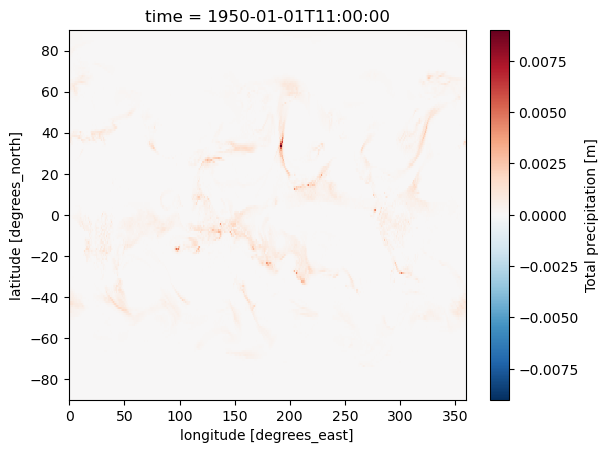

In [32]:
data_tp.tp.isel(time = 0).plot()